In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gp
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Business Dataset

In [4]:
business = pd.read_json('Data/yelp_dataset/business.json',lines=True)
business.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC


In [4]:
business.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state'],
      dtype='object')

In [5]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


## Just keep Restaurants in Las Vegas

In [6]:
business=business[['business_id','categories','city','latitude','longitude','stars']]
business.dropna(inplace=True)
for index, row in business.iterrows():
    if 'Restaurant' in row.categories:
        business.at[index,'Restaurant']=True
        
business.dropna(inplace=True)
del business['Restaurant']
business=business.loc[business.city=='Las Vegas']
business.head()

,business_id,categories,city,latitude,longitude,stars
17,PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,36.100016,-115.128529,4.0
25,tstimHoMcYbkSC4eBA1wEg,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,36.195615,-115.040529,4.5
75,kANF0dbeoW34s2vwh6Umfw,"Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,36.125031,-115.225620,2.0
111,X8mtoSxY8whtmbDlj0D3Aw,"Restaurants, Chinese",Las Vegas,36.238596,-115.233331,2.0
135,bJP4l_BGq2CudEu0m-wNjg,"Restaurants, Pizza, Italian, American (New)",Las Vegas,36.143672,-115.169792,2.0


In [7]:
business.shape

(6455, 6)

# Reviews Dataset

In [8]:
review = pd.read_json('Data/yelp_dataset/review.json',lines=True, chunksize=10**5)

In [9]:
reviews=pd.DataFrame(columns=['business_id','stars','text','user_id'])
for chunk in review:
    chunk=chunk[['business_id','stars','text','user_id']]
    reviews=pd.concat([reviews,chunk])
    
reviews.head()

,business_id,stars,text,user_id
0,ujmEBvifdJM6h6RLv4wQIg,1,Total bill for this horrible service? Over $8G...,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,5,I *adore* Travis at the Hard Rock's new Kelly ...,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,5,I have to say that this office really has it t...,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,5,Went in for a lunch. Steak sandwich was delici...,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,1,Today was my second out of three sessions I ha...,ssoyf2_x0EQMed6fgHeMyQ


In [10]:
reviews.shape

(6685900, 4)

## Keeping Reviews for Las Vegas Restaurants

In [11]:
#del business['categories']
reviews_lv=reviews.merge(business[['business_id']],on='business_id')
reviews_lv.head()

,business_id,stars,text,user_id
0,8mIrX_LrOnAqWsB5JrOojQ,4,"Like walking back in time, every Saturday morn...",FIk4lQQu1eTe2EpzQ4xhBA
1,8mIrX_LrOnAqWsB5JrOojQ,4,This is a really quaint place for the whole fa...,EfnzVzqWJUVEv8ft3fW2sQ
2,8mIrX_LrOnAqWsB5JrOojQ,5,Yes! As good as it gets in way of pinball mach...,LM3neYWMOghn2bgvYNRi7g
3,8mIrX_LrOnAqWsB5JrOojQ,3,The first & most important thing you need to k...,UEKG996TTiwonMpXwH-ixQ
4,8mIrX_LrOnAqWsB5JrOojQ,5,Pinball machines are slowly working their way ...,yMh4OF_Li2gJzE5rJ8oCbA


In [12]:
reviews_lv.shape

(1242789, 4)

In [77]:
reviews_lv.tail()

,business_id,stars,text,user_id
1242784,ESDIZvGMiFl7MfriZpXEqw,3,Noisy and crowded. The school monkeys are a ho...,1e-YlTcTpYKkCu6d_7kSJQ
1242785,ESDIZvGMiFl7MfriZpXEqw,5,Double double! Any day any time. Delicious bur...,0auqluusTrYQ0mEVUWbFvQ
1242786,ESDIZvGMiFl7MfriZpXEqw,5,Great experience. I've visited this location ...,q7gIbl0DUbr5bYgsMMWVWg
1242787,ESDIZvGMiFl7MfriZpXEqw,5,Great burgers and fantastic service at an affo...,pqeKwWu7n2hJuvh1I7DMZA
1242788,ESDIZvGMiFl7MfriZpXEqw,5,Not sure when this location opened but I went ...,Hx2OzzMpnGLVZTWI_qg1IA


In [15]:
reviews_lv.to_csv('Data/LV_Reviews_Text.csv', encoding='utf-8-sig',index=False)

In [47]:
#reviews_lv.to_csv('Data/LV_Reviews_Categories.csv', encoding='utf-8-sig',index=False)

In [117]:
reviews.stars=reviews.stars.astype(int)
user_no_reviews=reviews.groupby(['user_id']).agg({'business_id':'size','stars':'mean'}).rename(columns={'business_id':'Total_Reviews','stars':'Avg_Stars'}).reset_index()
user_no_reviews.head()

,user_id,Total_Reviews,Avg_Stars
0,---1lKK3aKOuomHnwAkAow,56,3.589286
1,---udAKDsn0yQXmzbWQNSw,2,4.500000
2,--0sXNBv6IizZXuV-nl0Aw,1,5.000000
3,--0zxhZTSLZ7w1hUD2bEwA,1,5.000000
4,--1mPJZdSY9KluaBYAGboQ,1,5.000000


In [122]:
user_no_reviews.shape

(423210, 3)

In [136]:
user_no_reviews.describe()

,Total_Reviews,Avg_Stars
count,423210.000000,423210.000000
mean,2.757716,3.723941
std,7.760111,1.382117
min,1.000000,1.000000
25%,1.000000,3.000000
50%,1.000000,4.000000
75%,2.000000,5.000000
max,1309.000000,5.000000


(array([ 54164.,   2581.,  25352.,   7582.,   4793.,  44797.,  28087.,
         63886.,  26602., 165366.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

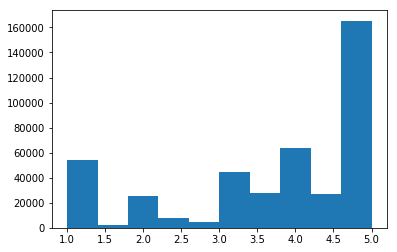

In [137]:
plt.hist(user_no_reviews.Avg_Stars)

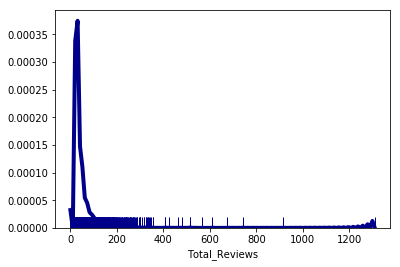

In [134]:
import seaborn as sns
sns.distplot(user_no_reviews.Total_Reviews,rug=True, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
#reviews.to_csv('Data/LV_Restaurant_Reviews.csv', encoding='utf-8-sig')

In [ ]:
#review.to_csv('Data/Agg_Reviews_Stars.csv',encoding='utf-8-sig')

In [139]:
reviews.head()

,business_id,stars,user_id,city,latitude,longitude
0,pH0BLkL4cbxKzu471VZnuA,5,LoMKP9SLsDHUZV0ZE9TQ3A,Las Vegas,36.124582,-115.167553
1,pH0BLkL4cbxKzu471VZnuA,5,ozO-5ZxPT07pXyCdxRFhug,Las Vegas,36.124582,-115.167553
2,pH0BLkL4cbxKzu471VZnuA,1,IcUwiYi6SUI7Eo-hwBWedA,Las Vegas,36.124582,-115.167553
3,pH0BLkL4cbxKzu471VZnuA,5,2YXT9mMPe8McTBAox4BBtg,Las Vegas,36.124582,-115.167553
4,pH0BLkL4cbxKzu471VZnuA,1,vGk-ePtd6sKJtnaYgyN9lw,Las Vegas,36.124582,-115.167553


In [140]:
user_variance=reviews.groupby(['user_id']).agg({'latitude':'mean','longitude':'mean'}).rename(columns={'latitude':'centroid_lat','longitude':'centroid_long'}).reset_index()
user_variance.head()

,user_id,centroid_lat,centroid_long
0,---1lKK3aKOuomHnwAkAow,36.146344,-115.252731
1,---udAKDsn0yQXmzbWQNSw,36.098651,-115.235599
2,--0sXNBv6IizZXuV-nl0Aw,36.196944,-115.262117
3,--0zxhZTSLZ7w1hUD2bEwA,35.994950,-115.206218
4,--1mPJZdSY9KluaBYAGboQ,36.084293,-115.293878


In [146]:
user_variance=user_variance.set_index('user_id')
reviews['centroid_lat']=reviews['user_id'].map(user_variance['centroid_lat'])
reviews['centroid_long']=reviews['user_id'].map(user_variance['centroid_long'])
reviews.head()

,business_id,stars,user_id,city,latitude,longitude,centroid_lat,centroid_long
0,pH0BLkL4cbxKzu471VZnuA,5,LoMKP9SLsDHUZV0ZE9TQ3A,Las Vegas,36.124582,-115.167553,36.123746,-115.169134
1,pH0BLkL4cbxKzu471VZnuA,5,ozO-5ZxPT07pXyCdxRFhug,Las Vegas,36.124582,-115.167553,36.114428,-115.173621
2,pH0BLkL4cbxKzu471VZnuA,1,IcUwiYi6SUI7Eo-hwBWedA,Las Vegas,36.124582,-115.167553,36.148290,-115.157092
3,pH0BLkL4cbxKzu471VZnuA,5,2YXT9mMPe8McTBAox4BBtg,Las Vegas,36.124582,-115.167553,36.124582,-115.167553
4,pH0BLkL4cbxKzu471VZnuA,1,vGk-ePtd6sKJtnaYgyN9lw,Las Vegas,36.124582,-115.167553,36.124582,-115.167553


In [147]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [150]:
user_variance=reviews[['user_id','latitude', 'longitude','centroid_lat', 'centroid_long']]
for index, row in user_variance.iterrows():    
    user_variance.at[index,'dist']=haversine(row.longitude,row.latitude,row.centroid_long,row.centroid_lat)
    
user_variance.head()

,user_id,latitude,longitude,centroid_lat,centroid_long,dist
0,LoMKP9SLsDHUZV0ZE9TQ3A,36.124582,-115.167553,36.123746,-115.169134,0.169761
1,ozO-5ZxPT07pXyCdxRFhug,36.124582,-115.167553,36.114428,-115.173621,1.253724
2,IcUwiYi6SUI7Eo-hwBWedA,36.124582,-115.167553,36.148290,-115.157092,2.798585
3,2YXT9mMPe8McTBAox4BBtg,36.124582,-115.167553,36.124582,-115.167553,0.000000
4,vGk-ePtd6sKJtnaYgyN9lw,36.124582,-115.167553,36.124582,-115.167553,0.000000


In [151]:
user_variance.describe()

,latitude,longitude,centroid_lat,centroid_long,dist
count,1.167093e+06,1.167093e+06,1.167093e+06,1.167093e+06,1.167093e+06
mean,3.612130e+01,-1.151934e+02,3.612130e+01,-1.151934e+02,3.322857e+00
std,4.765990e-02,5.460900e-02,3.472839e-02,4.032052e-02,3.615710e+00
min,3.592088e+01,-1.154530e+02,3.592088e+01,-1.154530e+02,0.000000e+00
25%,3.610326e+01,-1.152241e+02,3.610664e+01,-1.152182e+02,1.854393e-01
50%,3.611724e+01,-1.151751e+02,3.611756e+01,-1.151796e+02,2.138392e+00
75%,3.614335e+01,-1.151657e+02,3.613374e+01,-1.151700e+02,5.392578e+00
max,3.638197e+01,-1.148963e+02,3.638197e+01,-1.148963e+02,4.029680e+01


In [152]:
user_variance=user_variance.groupby(['user_id'])['dist'].var()
user_variance.head()

user_id
---1lKK3aKOuomHnwAkAow    16.216284
---udAKDsn0yQXmzbWQNSw     0.000003
--0sXNBv6IizZXuV-nl0Aw          NaN
--0zxhZTSLZ7w1hUD2bEwA          NaN
--1mPJZdSY9KluaBYAGboQ          NaN
Name: dist, dtype: float64

In [159]:
user_variance.fillna(0,inplace=True)

In [162]:
user_variance=user_variance.reset_index()
user_variance.describe()

,dist
count,4.232100e+05
mean,1.270706e+00
std,4.073685e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,3.202661e-07
max,1.454042e+02


In [164]:
user_variance.rename(columns={'dist':'variance'},inplace=True)
user_variance.head(1)

,user_id,variance
0,---1lKK3aKOuomHnwAkAow,16.216284


(array([4.13969e+05, 7.99500e+03, 1.01200e+03, 1.78000e+02, 4.20000e+01,
        6.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([  0.        ,  14.54042333,  29.08084665,  43.62126998,
         58.16169331,  72.70211663,  87.24253996, 101.78296329,
        116.32338661, 130.86380994, 145.40423327]),
 <a list of 10 Patch objects>)

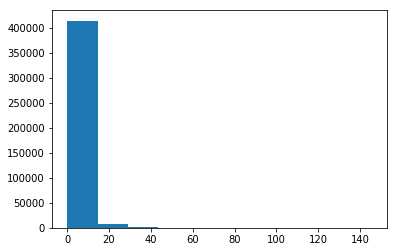

In [165]:
plt.hist(user_variance.variance)

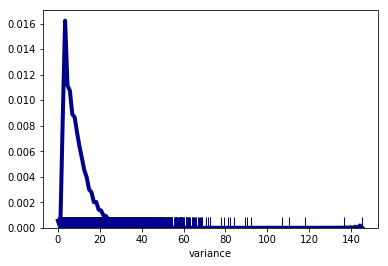

In [166]:
sns.distplot(user_variance.variance,rug=True, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [167]:
user_variance.to_csv('Data/LV_User_Loc_Var.csv',encoding='utf-8-sig')

In [ ]:
# Avergae stars and total reviews in Las Ve

In [46]:
review=pd.DataFrame(columns=['user_id','Total_Reviews','Avg_Stars'])
review

,user_id,Total_Reviews,Avg_Stars


In [47]:
for chunk in pd.read_json('Data/yelp_dataset/review.json',lines=True, chunksize=10**5):
    review = pd.concat([review,chunk.groupby(['user_id']).agg({'business_id':'size','stars':'mean'}).rename(columns={'business_id':'Total_Reviews','stars':'Avg_Stars'}).reset_index()]).groupby(['user_id']).agg({'Total_Reviews':'sum','Avg_Stars':'mean'}).reset_index()

In [48]:
review.describe()

,Total_Reviews,Avg_Stars
count,1.637138e+06,1.637138e+06
mean,4.083895e+00,3.634935e+00
std,1.469266e+01,1.476091e+00
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,2.500000e+00
50%,1.000000e+00,4.000000e+00
75%,3.000000e+00,5.000000e+00
max,4.129000e+03,5.000000e+00


In [49]:
review.head()

,user_id,Total_Reviews,Avg_Stars
0,---1lKK3aKOuomHnwAkAow,128,2.900173
1,---89pEy_h9PvHwcHNbpyg,1,5.000000
2,---94vtJ_5o_nikEs6hUjg,4,5.000000
3,---PLwSf5gKdIoVnyRHgBA,2,4.000000
4,---cu1hq55BP9DWVXXKHZg,3,1.750000


In [50]:
review.tail()

,user_id,Total_Reviews,Avg_Stars
1637133,zzzTrQ2bkvteEngjkXCTAA,2,5.0
1637134,zzzaIBwimxVej4tY6qFOUQ,1,5.0
1637135,zzzfcCWPDkg-kGVpqCKCEg,2,5.0
1637136,zzzhFxwfzL56CQVnw8piTw,1,5.0
1637137,zzzmshdEWLFCApxETl1TGQ,2,5.0


In [51]:
#review.to_csv('Data/Agg_Reviews_Stars.csv',encoding='utf-8-sig')

In [ ]:
lv=pd.DataFrame(columns=['business_id','Total_Reviews','Avg_Stars'])
lv

In [ ]:
for chunk in pd.read_json('Data/yelp_dataset/review.json',lines=True, chunksize=10**5):
    lv = pd.concat([lv,chunk.groupby(['user_id']).agg({'business_id':'size','stars':'mean'}).rename(columns={'business_id':'Total_Reviews','stars':'Avg_Stars'}).reset_index()]).groupby(['user_id']).agg({'Total_Reviews':'sum','Avg_Stars':'mean'}).reset_index()

In [59]:
business.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars', 'state'],
      dtype='object')

In [60]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
7,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV
17,"1775 E Tropicana Ave, Ste 29","{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,None,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,89119,40,4.0,NV
18,,{'BusinessAcceptsCreditCards': 'True'},nh_kQ16QAoXWwqZ05MPfBQ,"Event Planning & Services, Photographers, Prof...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",1,36.116549,-115.088115,Myron Hensel Photography,89121,21,5.0,NV
20,"450 Fremont St, Ste 179",{'GoodForKids': 'True'},dFMxzHygTy6F873843dHAA,"Arcades, Arts & Entertainment",Las Vegas,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",1,36.169993,-115.140685,Fremont Arcade,89101,38,4.5,NV
22,6007 Dean Martin Dr,"{'BikeParking': 'False', 'Ambience': '{'romant...",KWywu2tTEPWmR9JnBc0WyQ,"Nightlife, Arts & Entertainment, Bars, Strip C...",Las Vegas,"{'Thursday': '19:30-2:0', 'Friday': '19:30-3:0...",1,36.080168,-115.182756,Hunk Mansion,89118,107,4.0,NV


# Maturity Feature

In [5]:
reviews_lv = pd.read_csv('Data/LV_Reviews_Categories.csv')
reviews_lv.head()

,business_id,stars,user_id,categories
0,8mIrX_LrOnAqWsB5JrOojQ,4,FIk4lQQu1eTe2EpzQ4xhBA,"Performing Arts, Amusement Parks, Museums, Arc..."
1,8mIrX_LrOnAqWsB5JrOojQ,4,EfnzVzqWJUVEv8ft3fW2sQ,"Performing Arts, Amusement Parks, Museums, Arc..."
2,8mIrX_LrOnAqWsB5JrOojQ,5,LM3neYWMOghn2bgvYNRi7g,"Performing Arts, Amusement Parks, Museums, Arc..."
3,8mIrX_LrOnAqWsB5JrOojQ,3,UEKG996TTiwonMpXwH-ixQ,"Performing Arts, Amusement Parks, Museums, Arc..."
4,8mIrX_LrOnAqWsB5JrOojQ,5,yMh4OF_Li2gJzE5rJ8oCbA,"Performing Arts, Amusement Parks, Museums, Arc..."


In [6]:
users_lv=reviews_lv.groupby(['user_id'])['stars'].mean().reset_index()
users_lv.head()

,user_id,stars
0,---1lKK3aKOuomHnwAkAow,3.62069
1,---udAKDsn0yQXmzbWQNSw,4.50000
2,--0sXNBv6IizZXuV-nl0Aw,5.00000
3,--0zxhZTSLZ7w1hUD2bEwA,5.00000
4,--1mPJZdSY9KluaBYAGboQ,5.00000


In [7]:
user = pd.read_json('Data/yelp_dataset/user.json',lines=True, chunksize=10**5)

In [8]:
users=pd.DataFrame(columns=['user_id','average_stars','review_count','useful','yelping_since'])
for chunk in user:
    chunk=chunk[['user_id','average_stars','review_count','useful','yelping_since']]
    users=pd.concat([users,chunk])
    
users.head()

,user_id,average_stars,review_count,useful,yelping_since
0,l6BmjZMeQD3rDxWUbiAiow,4.03,95,84,2013-10-08 23:11:33
1,4XChL029mKr5hydo79Ljxg,3.63,33,48,2013-02-21 22:29:06
2,bc8C_eETBWL0olvFSJJd0w,3.71,16,28,2013-10-04 00:16:10
3,dD0gZpBctWGdWo9WlGuhlA,4.85,17,30,2014-05-22 15:57:30
4,MM4RJAeH6yuaN8oZDSt0RA,4.08,361,1114,2013-10-23 07:02:50


In [9]:
users['yelping_since'] =  pd.to_datetime(users['yelping_since'])
users.head()

,user_id,average_stars,review_count,useful,yelping_since
0,l6BmjZMeQD3rDxWUbiAiow,4.03,95,84,2013-10-08 23:11:33
1,4XChL029mKr5hydo79Ljxg,3.63,33,48,2013-02-21 22:29:06
2,bc8C_eETBWL0olvFSJJd0w,3.71,16,28,2013-10-04 00:16:10
3,dD0gZpBctWGdWo9WlGuhlA,4.85,17,30,2014-05-22 15:57:30
4,MM4RJAeH6yuaN8oZDSt0RA,4.08,361,1114,2013-10-23 07:02:50


In [10]:
#, format='%d%b%Y:%H:%M:%S.%f'

In [11]:
today = pd.to_datetime('05/15/2019')
for index, row in users.iterrows():
    users.at[index,'maturity']=row.review_count/(today-row.yelping_since).days
    
users.head()

,user_id,average_stars,review_count,useful,yelping_since,maturity
0,l6BmjZMeQD3rDxWUbiAiow,4.03,95,84,2013-10-08 23:11:33,0.046477
1,4XChL029mKr5hydo79Ljxg,3.63,33,48,2013-02-21 22:29:06,0.014518
2,bc8C_eETBWL0olvFSJJd0w,3.71,16,28,2013-10-04 00:16:10,0.007812
3,dD0gZpBctWGdWo9WlGuhlA,4.85,17,30,2014-05-22 15:57:30,0.009351
4,MM4RJAeH6yuaN8oZDSt0RA,4.08,361,1114,2013-10-23 07:02:50,0.177920


In [13]:
users_lv=users_lv.merge(users[['user_id','maturity']],on='user_id')
users_lv.head()

,user_id,maturity
0,---1lKK3aKOuomHnwAkAow,0.058459
1,---udAKDsn0yQXmzbWQNSw,0.030560
2,--0sXNBv6IizZXuV-nl0Aw,0.000432
3,--0zxhZTSLZ7w1hUD2bEwA,0.045059
4,--1mPJZdSY9KluaBYAGboQ,0.002090


In [15]:
users_lv.shape

(439173, 2)

In [17]:
reviews_lv['user_id'].nunique()

439173

In [18]:
from scipy import stats
for index, row in users_lv.iterrows():
    users_lv.at[index,'maturity_norm']=stats.percentileofscore(users_lv.maturity, row.maturity, kind='weak')
    
users_lv.head()

,user_id,maturity,maturity_norm
0,---1lKK3aKOuomHnwAkAow,0.058459,93.665822
1,---udAKDsn0yQXmzbWQNSw,0.030560,87.025386
2,--0sXNBv6IizZXuV-nl0Aw,0.000432,1.249394
3,--0zxhZTSLZ7w1hUD2bEwA,0.045059,91.360808
4,--1mPJZdSY9KluaBYAGboQ,0.002090,20.982164


In [19]:
users_lv.describe()

,maturity,maturity_norm
count,439173.000000,439173.000000
mean,0.017042,50.002026
std,0.039910,28.866478
min,0.000000,0.000683
25%,0.002461,25.001537
50%,0.005879,50.000114
75%,0.015056,75.000057
max,3.957202,100.000000


In [20]:
users_lv.to_csv('Data/LV_User_Maturity.csv', encoding='utf-8-sig',index=False)

# NA

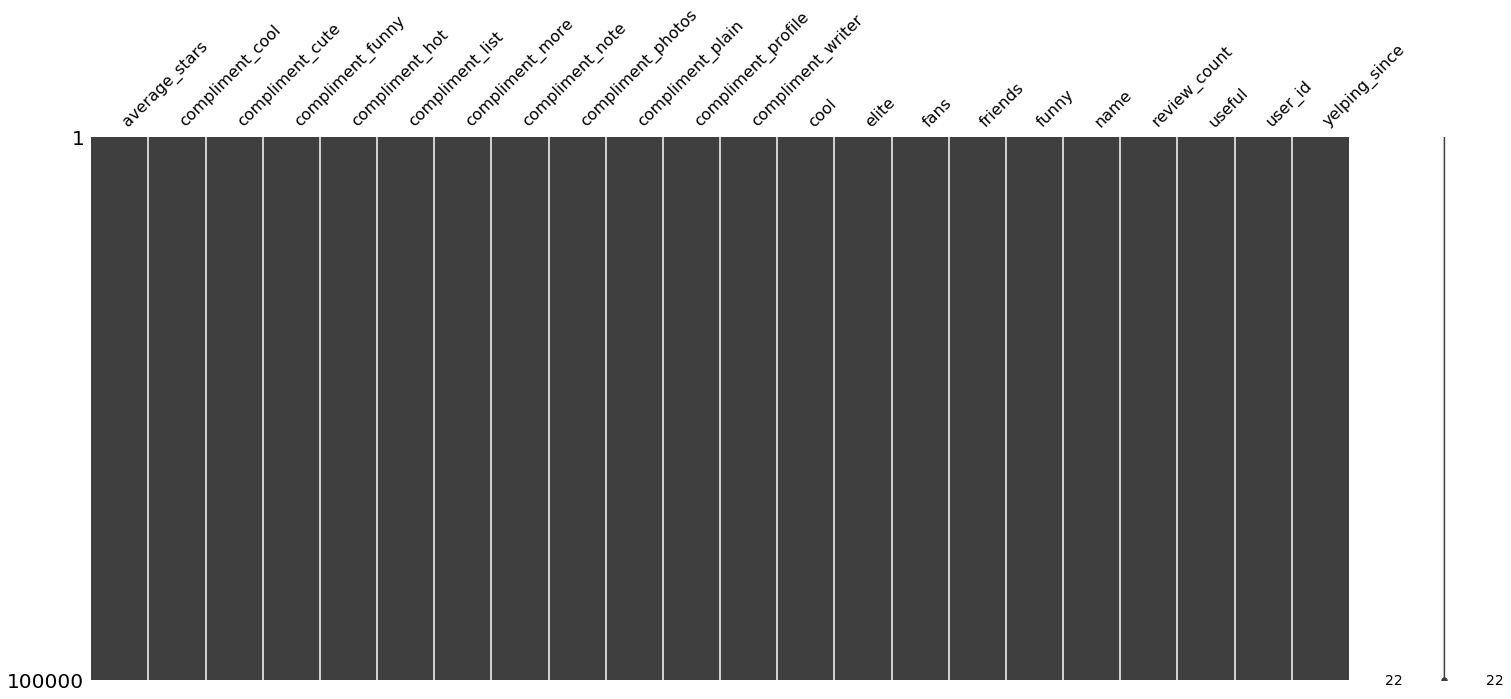

In [15]:
import missingno as msno
%matplotlib inline
msno.matrix(chunk)

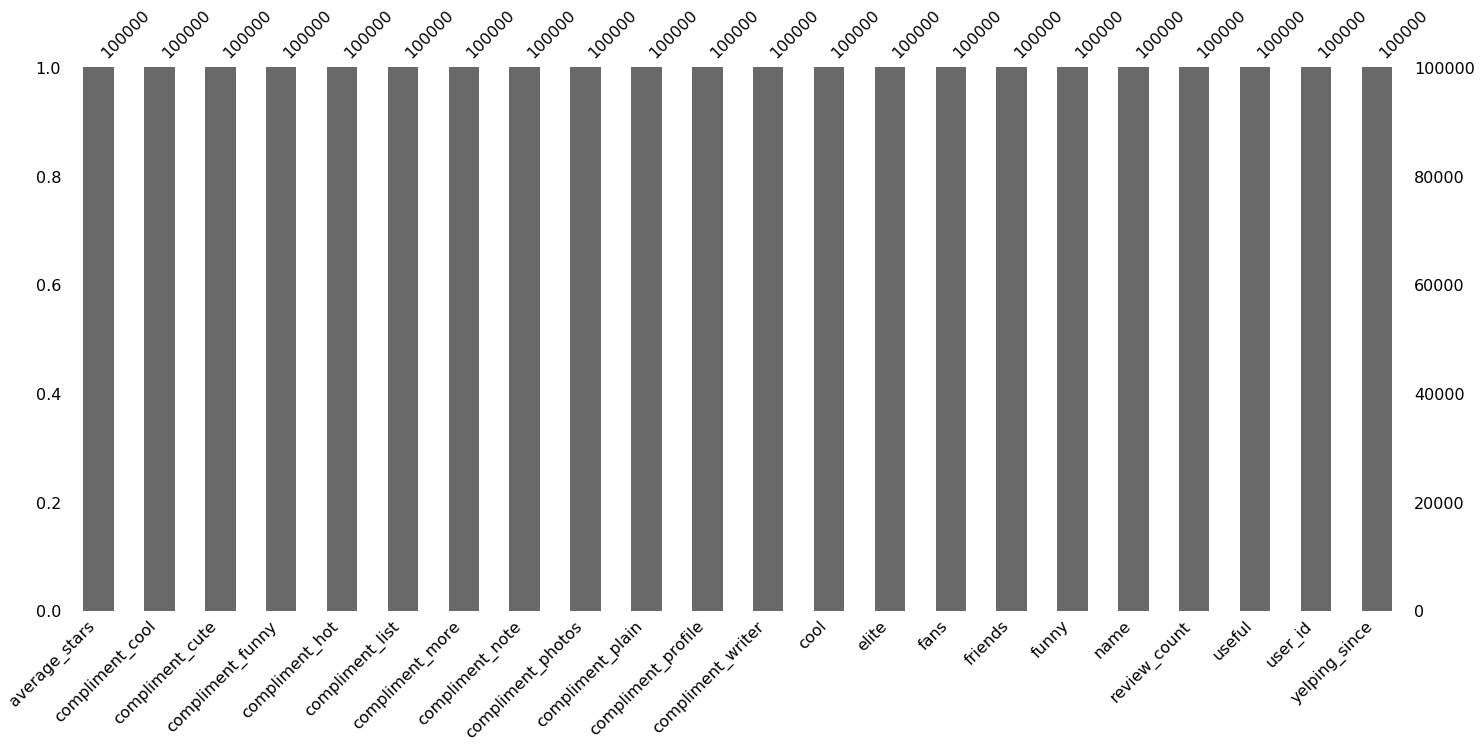

In [16]:
msno.bar(chunk)

# Heatmap Plot

In [ ]:
import folium
from folium.plugins import HeatMap
#Plot Map
SF_cood = (37.72, -122.25)
m = folium.Map(location=SF_cood, zoom_start=10)
df_copy = reviews.copy()
HeatMap(data=df_copy[['latitude', 'longitude', 'stars']].values.tolist(), radius=8, ).add_to(m)           
m.save('Output/HeatMap.html')
#Stamen Terrain
#m is Map Object
#‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’